### Classifying autistic patients upon the screening results with Logistic Regression

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer

### EDA

In [8]:
df = pd.read_csv(
    'Autism_Data.arff', 
    na_values='?',
)

In [9]:
data = df.copy()

In [10]:
data.shape

(704, 21)

In [11]:
data.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,'United States',no,6,'18 and more',Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5,'18 and more',Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8,'18 and more',Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,'United States',no,6,'18 and more',Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,NaN,no,no,Egypt,no,2,'18 and more',NaN,NO


Dataset contains ten behavioural features (AQ-10-Adult) plus ten individuals characteristics that have proved to be effective in detecting the ASD cases from controls in behaviour science.

In [12]:
data.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,702.000000,704.000000
mean,0.721591,0.453125,0.457386,0.495739,0.498580,0.284091,0.417614,0.649148,0.323864,0.573864,29.698006,4.875000
std,0.448535,0.498152,0.498535,0.500337,0.500353,0.451301,0.493516,0.477576,0.468281,0.494866,16.507465,2.501493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,3.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,27.000000,4.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,7.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,383.000000,10.000000


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 21 columns):
A1_Score           704 non-null int64
A2_Score           704 non-null int64
A3_Score           704 non-null int64
A4_Score           704 non-null int64
A5_Score           704 non-null int64
A6_Score           704 non-null int64
A7_Score           704 non-null int64
A8_Score           704 non-null int64
A9_Score           704 non-null int64
A10_Score          704 non-null int64
age                702 non-null float64
gender             704 non-null object
ethnicity          609 non-null object
jundice            704 non-null object
austim             704 non-null object
contry_of_res      704 non-null object
used_app_before    704 non-null object
result             704 non-null int64
age_desc           704 non-null object
relation           609 non-null object
Class/ASD          704 non-null object
dtypes: float64(1), int64(11), object(9)
memory usage: 115.6+ KB


In [14]:
data.dtypes.value_counts()

int64      11
object      9
float64     1
dtype: int64

Dataset has **704** examples and **21** features. 11 of them are ints, 9 are objects and 1 is float.

### MISSING VALUES

In [9]:
total_missing_data = data.isnull().sum().sort_values(ascending=False)

percent_of_missing_data = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)

missing_data = pd.concat(
    [
        total_missing_data, 
        percent_of_missing_data
    ], 
    axis=1, 
    keys=['Total', 'Percent']
)

missing_data.head()

,Total,Percent
ethnicity,95,13.494318
relation,95,13.494318
age,2,0.284091
A9_Score,0,0.000000
A2_Score,0,0.000000


In [10]:
data.iloc[:, 0:10].sum(axis=1).head(10)

0    6
1    5
2    8
3    6
4    2
5    9
6    2
7    5
8    6
9    8
dtype: int64

**result** column is a sum of all a*_score columns.

### YES-NO into 0-1

In [11]:
data.columns = map(lambda x: x.strip().lower(), data.columns)

In [12]:
data.rename(columns={'class/asd': 'decision_class'}, inplace=True)

In [13]:
data.jundice = data.jundice.apply(lambda x: 0 if x == 'no' else 1)

In [14]:
data.austim = data.austim.apply(lambda x: 0 if x == 'no' else 1)

In [15]:
data.used_app_before = data.used_app_before.apply(lambda x: 0 if x == 'no' else 1)

In [16]:
data.decision_class = data.decision_class.apply(lambda x: 0 if x == 'NO' else 1)

### GENDER M-F to 0-1

In [17]:
le = LabelEncoder()

data.gender = le.fit_transform(data.gender) 

#### STRING VALUES CLEANING

In [18]:
data.contry_of_res = data.contry_of_res.astype('str')
data.contry_of_res = data.contry_of_res.str.lower()
data.contry_of_res = data.contry_of_res.str.replace("'", "")
data.contry_of_res = data.contry_of_res.str.strip()

In [19]:
data.relation = data.relation.replace(np.nan, 'unknown', regex=True)
data.relation = data.relation.astype('str')
data.relation = data.relation.str.lower()
data.relation = data.relation.str.replace("'", "")
data.relation = data.relation.str.strip()

In [20]:
data.ethnicity = data.ethnicity.replace(np.nan, 'unknown', regex=True)
data.ethnicity = data.ethnicity.astype('str')
data.ethnicity = data.ethnicity.str.lower()
data.ethnicity = data.ethnicity.str.replace("'", "")
data.ethnicity = data.ethnicity.str.strip()

#### GENDER VS DECISSION CLASS

In [23]:
data.gender[data.decision_class == 0].value_counts() # 0-female, 1-male

1    281
0    234
Name: gender, dtype: int64

In [24]:
data.gender[data.decision_class == 1].value_counts() # 0-female, 1-male

0    103
1     86
Name: gender, dtype: int64

ASD is diagnosed more commonly in **females** than males.

#### ETHNICITY VS DECISSION CLASS

In [25]:
data.ethnicity[data.decision_class == 0].value_counts()

white-european    124
asian             107
unknown            86
middle eastern     84
south asian        33
black              25
others             22
pasifika           11
latino             10
hispanic            8
turkish             5
Name: ethnicity, dtype: int64

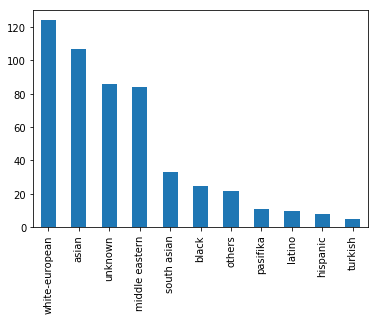

In [26]:
data.ethnicity[data.decision_class == 0].value_counts().plot(kind='bar')

In [27]:
data.ethnicity[data.decision_class == 1].value_counts()

white-european    109
black              18
asian              16
latino             10
unknown             9
others              9
middle eastern      8
hispanic            5
south asian         3
turkish             1
pasifika            1
Name: ethnicity, dtype: int64

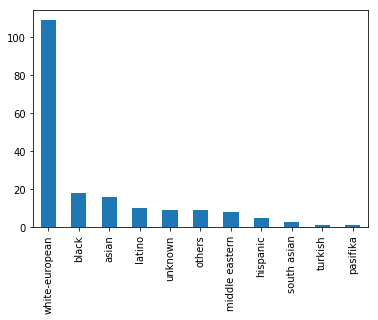

In [28]:
data.ethnicity[data.decision_class == 1].value_counts().plot(kind='bar')

ASD prevalence is reported to be highest among **white-european** people.

#### RELATION (WHO DID TEST) VS DECISSION CLASS

In [29]:
data.relation[data.decision_class == 0].value_counts()

self                        365
unknown                      86
parent                       38
relative                     19
others                        4
health care professional      3
Name: relation, dtype: int64

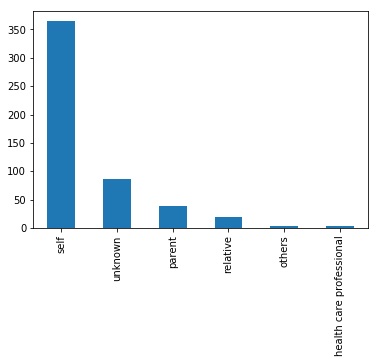

In [30]:
data.relation[data.decision_class == 0].value_counts().plot(kind='bar')

In [31]:
data.relation[data.decision_class == 1].value_counts()

self                        157
parent                       12
relative                      9
unknown                       9
health care professional      1
others                        1
Name: relation, dtype: int64

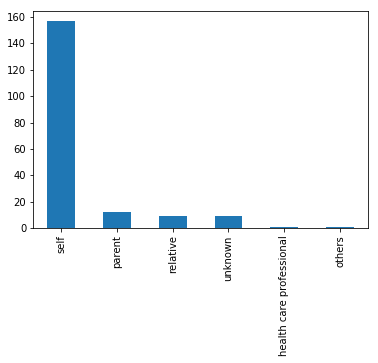

In [32]:
data.relation[data.decision_class == 1].value_counts().plot(kind='bar')

In [33]:
data.contry_of_res[data.decision_class == 0].value_counts().head(10)

united arab emirates    79
india                   75
new zealand             66
united states           60
united kingdom          48
jordan                  45
australia               15
sri lanka               14
afghanistan             11
iran                     7
Name: contry_of_res, dtype: int64

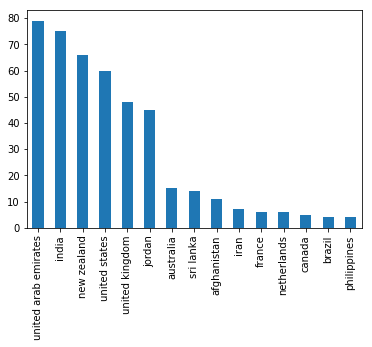

In [34]:
data.contry_of_res[data.decision_class == 0].value_counts().head(15).plot(kind='bar')

In [35]:
data.contry_of_res[data.decision_class == 1].value_counts().head(10)

united states     53
united kingdom    29
new zealand       15
australia         12
canada            10
india              6
france             5
brazil             5
mexico             4
italy              4
Name: contry_of_res, dtype: int64

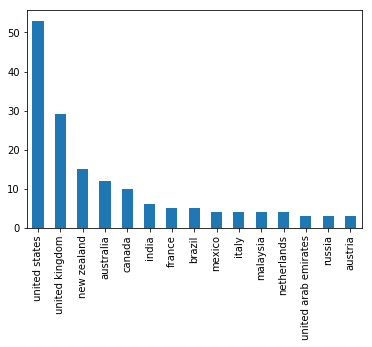

In [36]:
data.contry_of_res[data.decision_class == 1].value_counts().head(15).plot(kind='bar')

ASD prevalence is reported to be the highest among **USA** and **UK** citizens.

### LABEL BINARIZING

#### contry_of_res

In [37]:
lb = LabelBinarizer()

lb.fit(data.contry_of_res.values)

binarized_data = lb.transform(data.contry_of_res.values)

binarized_contry_of_res_matrix_data = np.vstack(binarized_data)

In [38]:
binarized_contry_of_res_matrix_data.shape

(704, 67)

#### relation

In [39]:
lb = LabelBinarizer()

lb.fit(data.relation.values)

binarized_data = lb.transform(data.relation.values)

binarized_result_matrix_data = np.vstack(binarized_data)

In [40]:
binarized_result_matrix_data.shape

(704, 6)

#### ethnicity

In [41]:
lb = LabelBinarizer()

lb.fit(data.ethnicity.values)

binarized_data = lb.transform(data.ethnicity.values)

binarized_ethnicity_matrix_data = np.vstack(binarized_data)

In [42]:
binarized_ethnicity_matrix_data.shape

(704, 11)

In [43]:
data.drop(['age_desc', 'result'], axis=1, inplace=True)

I'm dropping **age_desc** and **result** columns, because there's no such relation between other attributes.

We can assume **age_desc** column represents the information whether the patient is an adult or not. Every row has the same value - "18 and more", so in our situation its redundant.

Also, **result** column is a sum of all a*_score columns.

In [44]:
data.head()

,a1_score,a2_score,a3_score,a4_score,a5_score,a6_score,a7_score,a8_score,a9_score,a10_score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,relation,decision_class
0,1,1,1,1,0,0,1,1,0,0,26.0,0,white-european,0,0,united states,0,self,0
1,1,1,0,1,0,0,0,1,0,1,24.0,1,latino,0,1,brazil,0,self,0
2,1,1,0,1,1,0,1,1,1,1,27.0,1,latino,1,1,spain,0,parent,1
3,1,1,0,1,0,0,1,1,0,1,35.0,0,white-european,0,1,united states,0,self,0
4,1,0,0,0,0,0,0,1,0,0,40.0,0,unknown,0,0,egypt,0,unknown,0


In [47]:
data.age.max(), data.age.min()

(383.0, 17.0)

In [48]:
print('The oldest patient: {} years.'.format(data.age.max()))
print('The youngest patient: {} years.'.format(data.age.min()))
print('Average age: {} years.'.format(data.age.mean()))
print('Median age: {} years.'.format(data.age.median(skipna=True)))

The oldest patient: 383.0 years.
The youngest patient: 17.0 years.
Average age: 29.698005698005698 years.
Median age: 27.0 years.


In [49]:
data.loc[(data.age == 383)]

,a1_score,a2_score,a3_score,a4_score,a5_score,a6_score,a7_score,a8_score,a9_score,a10_score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,relation,decision_class
52,1,0,0,0,0,0,0,0,0,0,383.0,0,pasifika,0,0,new zealand,0,self,0


We can either assume it's been put by a mistake and calculate mean/median value or delete that observation.

Here I will calculate a median value.

In [50]:
data.age.median()

27.0

In [51]:
data.age.replace(data.age.max(), data.age.median(), inplace=True)

C:\Users\Iqra Altaf\python\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Iqra Altaf\python\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


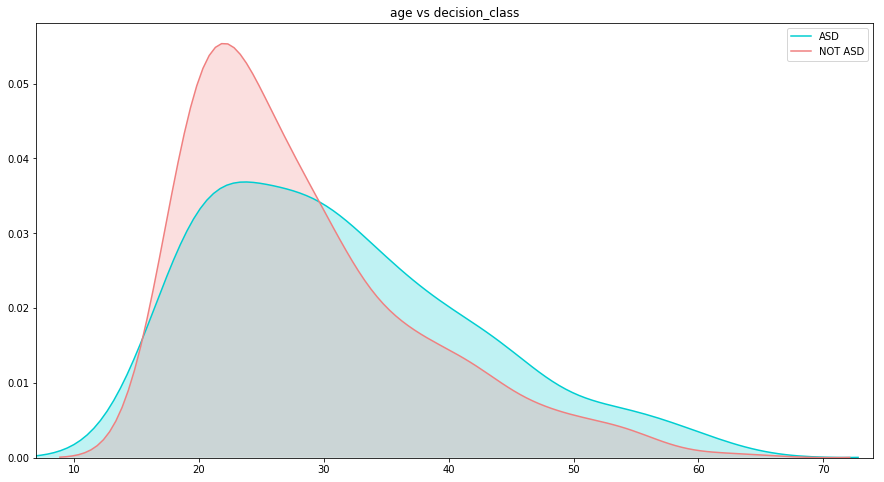

In [52]:
plt.figure(figsize=(15,8))

sns.kdeplot(
    data.age[data.decision_class == 1], 
    color="darkturquoise", 
    shade=True
)

sns.kdeplot(
    data.age[data.decision_class == 0], 
    color="lightcoral", 
    shade=True
)

plt.legend(['ASD', 'NOT ASD'])
plt.title('age vs decision_class')
plt.xlim(data.age.min() - 10, data.age.max() + 10)
plt.show()

In [53]:
data.decision_class.value_counts()

0    515
1    189
Name: decision_class, dtype: int64

In [54]:
data.gender[data.decision_class == 1].value_counts()

0    103
1     86
Name: gender, dtype: int64

In [55]:
data.gender[data.decision_class == 0].value_counts()

1    281
0    234
Name: gender, dtype: int64

In [56]:
data.isnull().sum()

a1_score           0
a2_score           0
a3_score           0
a4_score           0
a5_score           0
a6_score           0
a7_score           0
a8_score           0
a9_score           0
a10_score          0
age                2
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
relation           0
decision_class     0
dtype: int64

### MISSING VALUES IMPUTATION

In [57]:
to_update_nans_dict = {}

columns = [
    'age'
]

for _decision_class in [0, 1]:
    for column in columns:
        vals = data[data.decision_class == _decision_class][column].value_counts()
        
        to_update_nans_dict['{decision_class}_{column}'.format(
            decision_class=_decision_class,
            column=column
        )] = vals.idxmax()

In [58]:
to_update_nans_dict

{'0_age': 21.0, '1_age': 30.0}

In [59]:
data.iloc[62, data.columns.get_loc('age')] = to_update_nans_dict.get('0_age')

In [60]:
data.iloc[91, data.columns.get_loc('age')] = to_update_nans_dict.get('1_age')

### HEATMAP

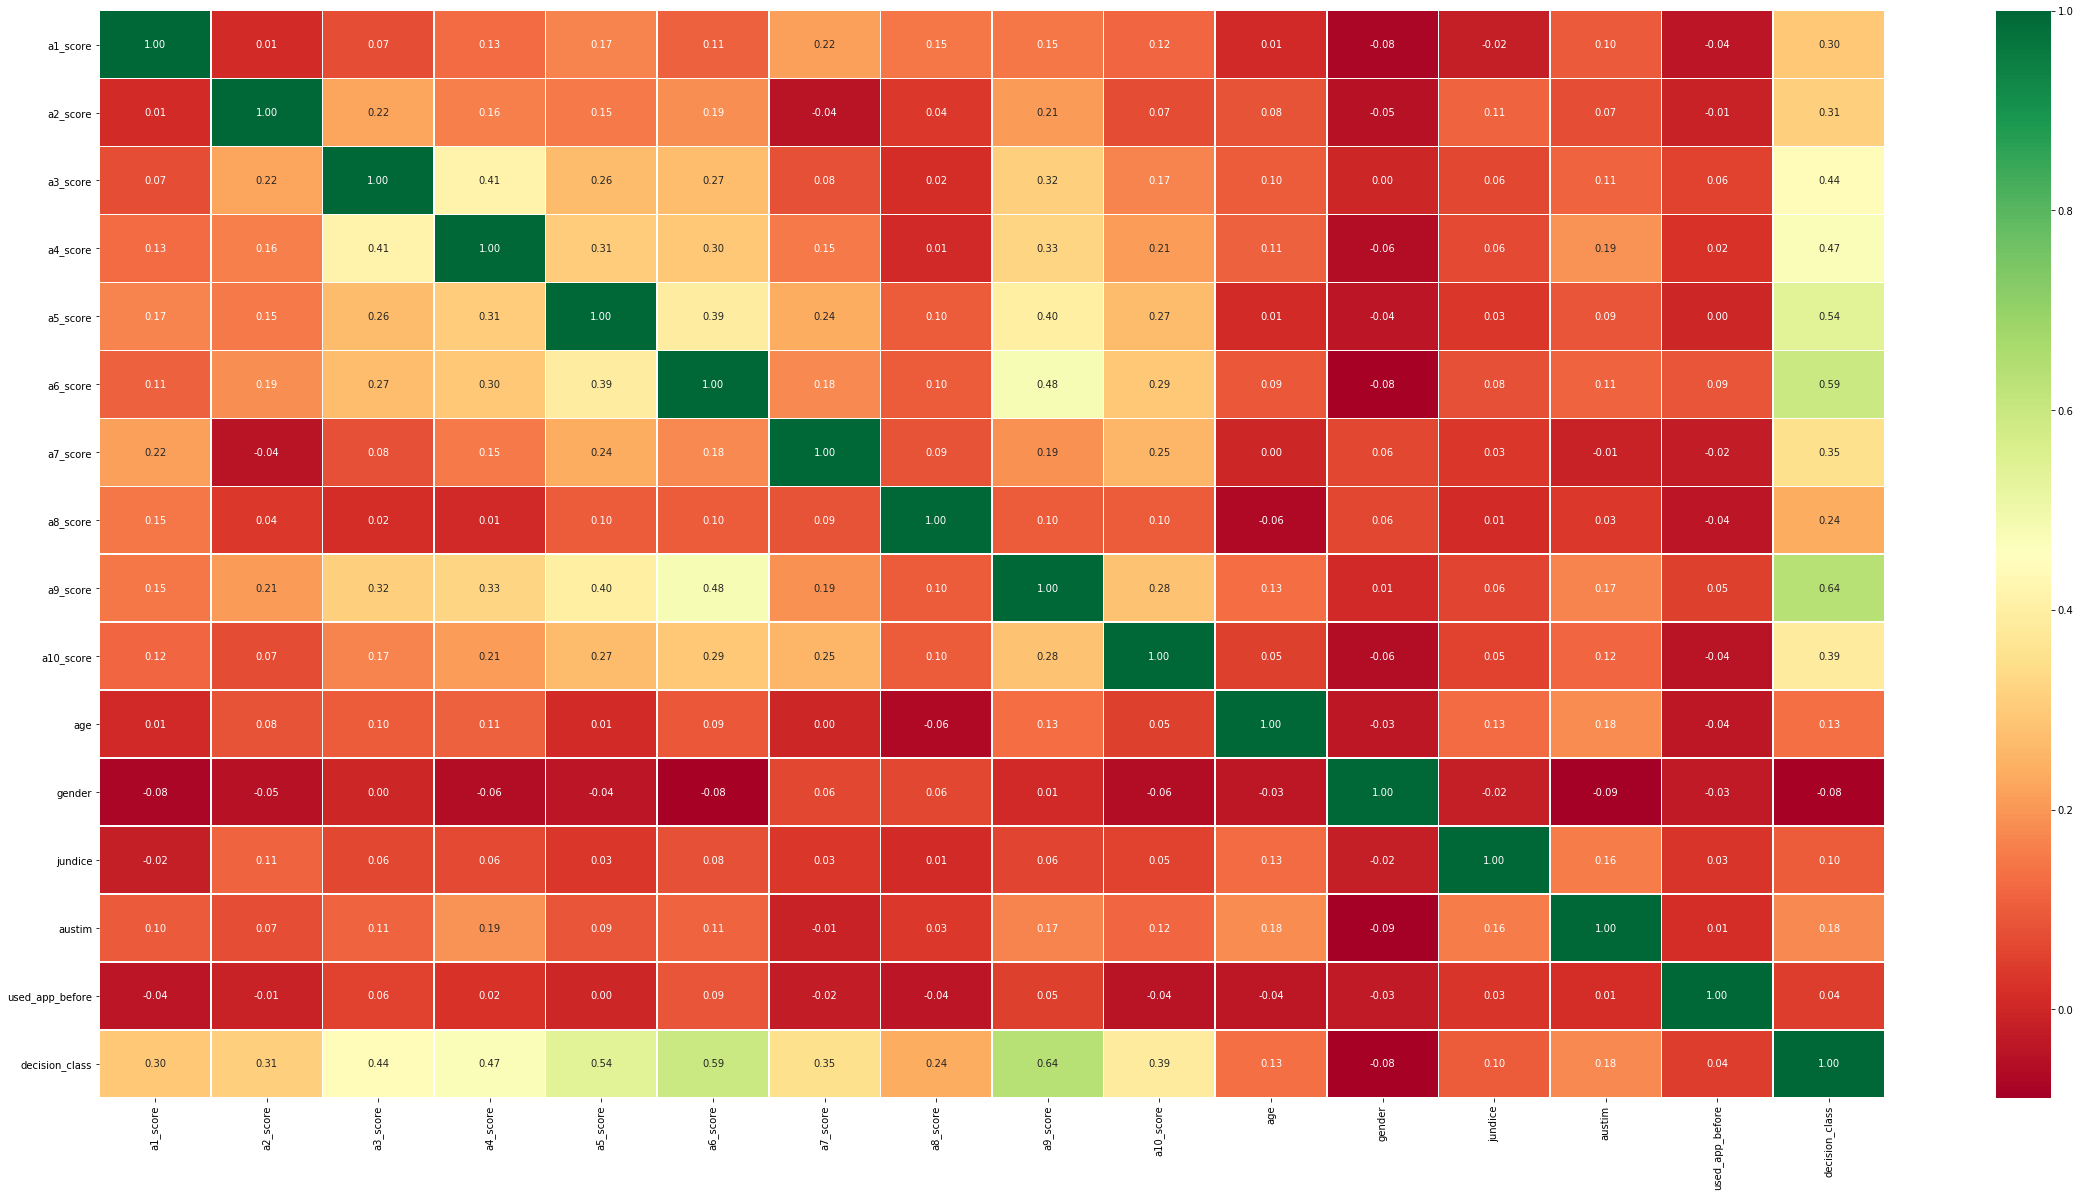

In [61]:
corr = data.corr()

sns.heatmap(
    data=corr,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cmap='RdYlGn',
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)

fig = plt.gcf()
fig.set_size_inches(40, 20)

plt.show()

### PREPARING DATA FOR MODEL

In [62]:
feature_names = list(
    set(data.columns[0:-1].tolist()).difference(['contry_of_res', 'relation', 'ethnicity'])
)

X = data[feature_names].as_matrix()

X_new = np.hstack((
    X, 
    binarized_contry_of_res_matrix_data,
    binarized_ethnicity_matrix_data,
    binarized_result_matrix_data,
))
                   
y = data.decision_class

C:\Users\Iqra Altaf\python\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [63]:
X_new.shape, y.shape

((704, 99), (704,))

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new,
    y,
    random_state=42,
    test_size=0.3
)

In [65]:
log_reg = LogisticRegression(
    C=1,
    penalty='l1',
    solver='liblinear',
    random_state=42,
    multi_class='ovr'

)

In [66]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l1', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [67]:
log_reg_predict = log_reg.predict(X_test)

In [68]:
log_reg.score(X_test, y_test)

1.0

In [69]:
preds = log_reg.predict(X_test)

In [70]:
log_reg_predict_proba = log_reg.predict_proba(X_test)[:, 1]

In [71]:
print('\nLogistic Regression Accuracy: {:.2f}%'.format(accuracy_score(y_test, log_reg_predict) * 100))
print('Logistic Regression AUC: {:.2f}%'.format(roc_auc_score(y_test, log_reg_predict) * 100))
print('Logistic Regression Classification report:\n\n', classification_report(y_test, log_reg_predict))


Logistic Regression Accuracy: 100.00%
Logistic Regression AUC: 100.00%
Logistic Regression Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00        57

   micro avg       1.00      1.00      1.00       212
   macro avg       1.00      1.00      1.00       212
weighted avg       1.00      1.00      1.00       212



In [72]:
print(confusion_matrix(y_test, preds))

[[155   0]
 [  0  57]]


### ROC

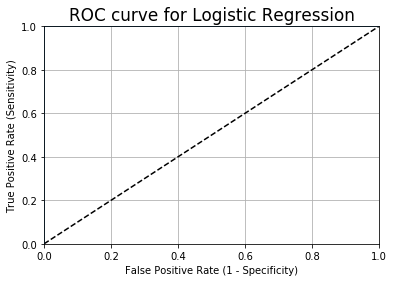

In [73]:
fpr, tpr, thresholds = roc_curve(
    y_test, 
    log_reg_predict_proba
)

plt.plot(
    [0, 1], 
    [0, 1], 
    'k--'
)

plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.rcParams['font.size'] = 14

plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.grid(True)

### F1 SCORE AFTER 10-FOLD CROSS-VALIDATION

In [74]:
kfold = StratifiedKFold(
    n_splits=10, 
    shuffle=True, 
    random_state=42
)

predicted = cross_val_predict(
    log_reg, 
    X_new, 
    y, 
    cv=kfold
)

scores = cross_val_score(
    log_reg, 
    X_new, 
    y, 
    cv=kfold,
    scoring='f1'
)

print('Cross-validated scores: {}\n'.format(scores))

print(classification_report(y, predicted))

print("\nLogisticRegression: F1 after 10-fold cross-validation: {:.2f}% (+/- {:.2f}%)".format(
    scores.mean() * 100,
    scores.std() * 2
))

Cross-validated scores: [0.97297297 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       515
           1       1.00      0.99      1.00       189

   micro avg       1.00      1.00      1.00       704
   macro avg       1.00      1.00      1.00       704
weighted avg       1.00      1.00      1.00       704


LogisticRegression: F1 after 10-fold cross-validation: 99.73% (+/- 0.02%)


Cross-validation minimizes classification error estimation bias and is thus primarily used for small sample datasets. As expected, the classification f1 score dropped from ∼100% for the full dataset to ∼99.75% with 10-fold or percentage-split cross-validation.